In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sample_contour_points(image_path, num_points):
    """
    이미지의 외곽선에서 균일한 거리를 가진 점들을 샘플링하는 함수

    :param image_path: 이미지 경로 (PNG 파일)
    :param num_points: 샘플링할 점의 수
    
    :return: 샘플링된 점들의 좌표 리스트
    """
    # 이미지를 그레이스케일로 읽어오고, 이진화
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    
    # 외곽선 찾기
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # 가장 큰 외곽선 선택
    contour = max(contours, key=cv2.contourArea)

    sampled_points = sample_contour_points_uniformly(contour, num_points)

    return sampled_points

In [3]:
def sample_contour_points_uniformly(contour, num_points):
    """
    주어진 외곽선에서 균일한 간격으로 정확히 num_points만큼의 점들을 샘플링합니다.
    마지막 점은 첫 번째 점과 동일하지 않습니다.
    
    :param contour: 단일 외곽선 (NumPy 배열)
    :param num_points: 샘플링할 점의 수
    
    :return: 샘플링된 점들의 좌표 리스트
    """
    # 외곽선을 따라 거리 계산
    cum_length = np.zeros(len(contour))
    for i in range(1, len(contour)):
        cum_length[i] = cum_length[i-1] + np.linalg.norm(contour[i] - contour[i-1])

    # 균일 간격의 거리 값, 마지막 점을 포함하지 않기 위해 num_points + 1로 계산
    distance_intervals = np.linspace(0, cum_length[-1], num_points + 1)[:-1] # 마지막 값을 제외

    # 샘플링된 점들의 인덱스를 찾고 해당 점들을 선택
    sampled_points = []
    for interval in distance_intervals:
        idx = np.where(cum_length >= interval)[0][0]
        sampled_points.append(contour[idx][0].tolist())
    
    return sampled_points

In [4]:
def compute_fourier_descriptors(sampled_points,sampling_num):
    
    # 샘플링된 점들의 좌표를 복소수 형태로 변환
    complex_points = np.array([x + y*1j for x, y in sampled_points])

    M = sampling_num
    A_m = np.zeros(M)
    B_m = np.zeros(M)

    for m in range(M):
        A_m_sum = 0
        B_m_sum = 0
        for k in range(M):
            x_k, y_k = sampled_points[k]
            angle = 2 * np.pi * m * k / M                           #phi 계산
            A_m_sum += x_k * np.cos(angle) + y_k * np.sin(angle)
            B_m_sum += y_k * np.cos(angle) - x_k * np.sin(angle)
        A_m[m] = A_m_sum / M
        B_m[m] = B_m_sum / M


    mid_num = M//2
    a = np.concatenate((A_m[mid_num+1:],A_m[:mid_num+1]))   # DC component를 중앙으로 위치시키는 과정
    b = np.concatenate((B_m[mid_num+1:],B_m[:mid_num+1]))   # DC component를 중앙으로 위치시키는 과정

    return a,b

In [5]:
def all_in_one(image_path,sampling_num):
    
    points = sample_contour_points(image_path,sampling_num)

    return compute_fourier_descriptors(points,sampling_num)

In [19]:
#------------------------------------------
#여기까지가 Fourier Descriptor를 구하는 과정
#------------------------------------------

In [17]:
def get_single_point(G, m_minus, m_plus, t):
    """
    Returns a single point (as a complex value) on the reconstructed shape for the continuous
    path position t, based on the Fourier coefficients G(m_minus),...,G(m_plus).
    """
    M = len(G)
    x, y = 0, 0
    for m in range(m_minus, m_plus + 1):
        phi = 2 * np.pi * m * t  # Compute the angle
        m_mod = m % M  # Wrap around if m exceeds the length of G
        G_m = G[m_mod]  # Fourier coefficient
        A_m = np.real(G_m)  # Real part
        B_m = np.imag(G_m)  # Imaginary part
        x += A_m * np.cos(phi) - B_m * np.sin(phi)  # Update x
        y += A_m * np.sin(phi) + B_m * np.cos(phi)  # Update y
    return complex(x, y)

def get_partial_reconstruction(G, Mp, N):
    """
    Reconstructs the shape as a sequence of N complex values using Mp Fourier descriptor pairs.
    """
    M = len(G)  # Total number of Fourier coefficients
    g = []  # The reconstructed points
    for k in range(N):  # For each point on the reconstructed shape
        t = k / N  # Continuous path position
        g.append(get_single_point(G, -Mp, Mp, t))
    return g

In [7]:
image_path = '[1]_re.png'
sampling_num = 63
a,b = all_in_one(image_path,sampling_num)

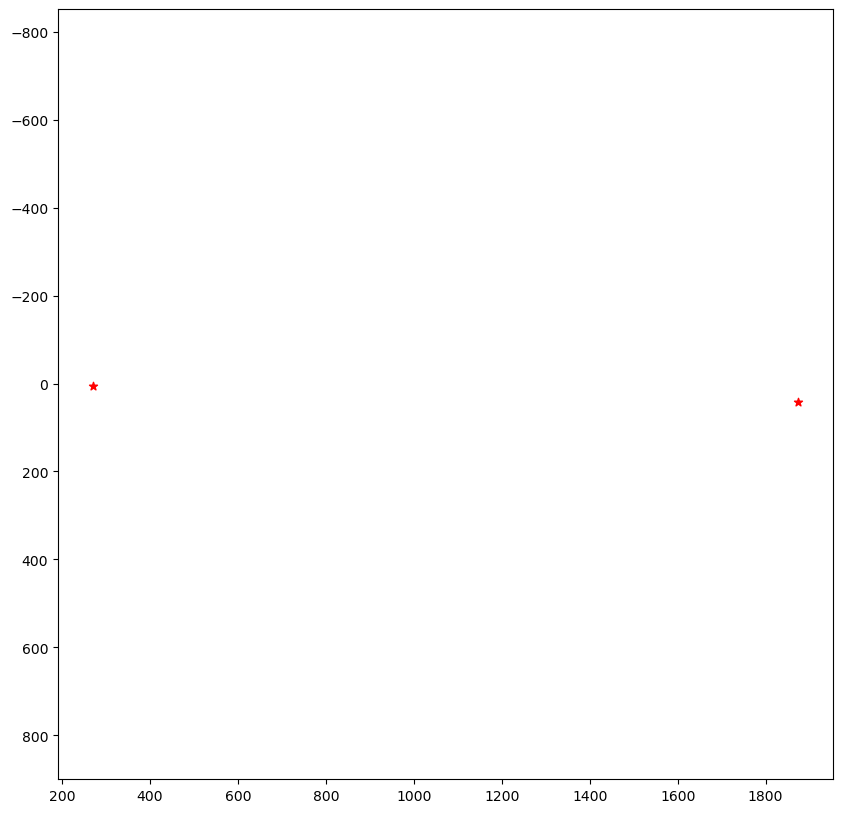

In [10]:
G=[]
for i in range(sampling_num):
    G.append(complex(a[i],b[i]))

recon_points = get_partial_reconstruction(G, 40, 128)


x_coords,y_coords = np.real(recon_points),np.imag(recon_points)

recon_point = (x_coords,y_coords)
plot_sampled_points(recon_point)

In [14]:
def plot_sampled_points(sampled_points):

    x_coords = [point[0] for point in sampled_points]
    y_coords = [point[1] for point in sampled_points]
    
    # 샘플링된 점들 시각화
    plt.figure(figsize=(10, 10))
    plt.scatter(x_coords, y_coords, c='red', marker='*')  # 빨간색 점으로 표시
    plt.gca().invert_yaxis()  # y축 방향을 이미지와 동일하게 설정 (위로 갈수록 값이 감소하도록)
    plt.axis('equal')  # x, y 축의 스케일을 동일하게 설정
    plt.show()

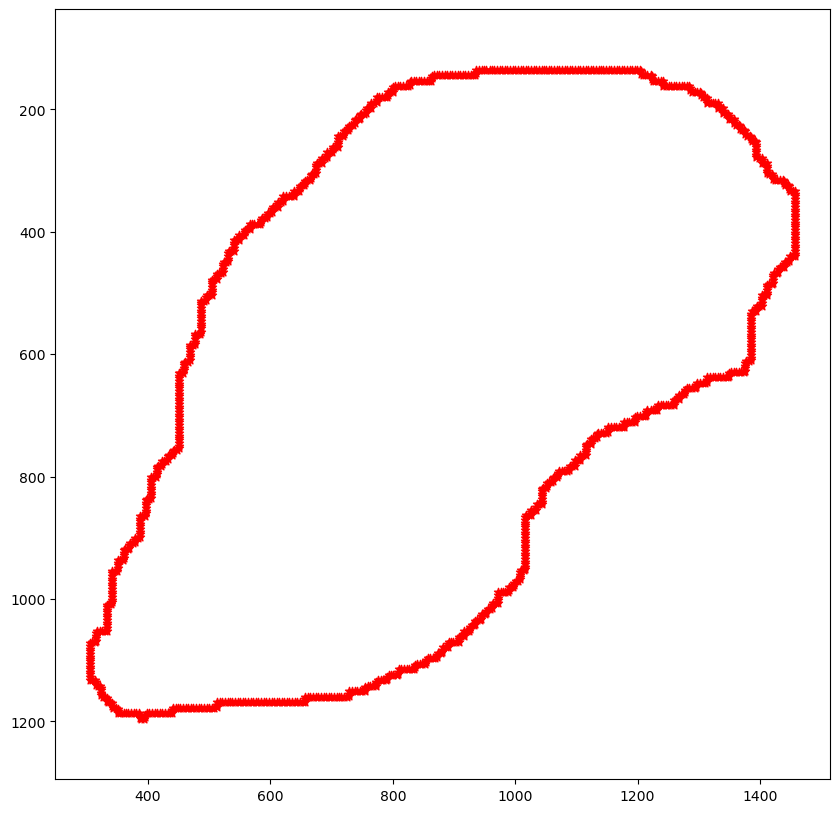

In [35]:
sampled_points = sample_contour_points(image_path, 1024)
plot_sampled_points(sampled_points)